In [ ]:
# PARAMETERS
GROUP_ID = 'Group11'
ALGORITHM = "ValItr"
TRACK_NAME = "/content/drive/MyDrive/tracks/W-track.txt"
CRASH_POS = 'STRT'

In [ ]:
# Mount Google Drive, unneccessary if not using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Racetrack Implementation

import random

# Track Loading/Representation
def load_track(file_path):
  # PARAMETERS
  # file_path: path to track file
  # RETURNS
  # rows: number of rows in track
  # columns: number of columns in track
  # grid: 2D list of strings, the track grid
  # start: list of tuples, starting positions
  # finish: list of tuples, finish positions
  # walls: list of tuples, wall positions
  # track: list of tuples, empty track cells

  # Read file
  with open(file_path, "r") as f:
    first_line = f.readline().strip()
    rows, columns = map(int, first_line.split(","))

    grid = []
    start_positions = []
    finish_positions = []
    walls = []
    track = []

    for r in range(rows):
      line = f.readline().strip()
      row_list = list(line)
      grid.append(row_list)

      # Classify each character appropriately
      for c, char in enumerate(row_list):
        if char == 'S':
          start_positions.append((r,c))
        if char == 'F':
          finish_positions.append((r,c))
        if char == '#':
          walls.append((r,c))
        if char == '.':
          track.append((r,c))

    return {
        "rows": rows,
        "columns": columns,
        "grid": grid,
        "start": start_positions,
        "finish": finish_positions,
        "walls": walls,
        "track": track
    }

# State Representation
# Check if state (position and velocity) is valid
def is_valid(position, velocity, grid):
  # PARAMETERS
  # position: (row, column) tuple of current position
  # velocity: tuple of current velocity
  # grid: 2D list of strings, the track grid
  # RETURNS
  # boolean: True if position and velocity are valid, false otherwise

  row, column = position
  vx, vy = velocity

  rows = len(grid)
  columns = len(grid[0])

  # Verify position is inside grid
  if row < 0 or row >= rows or column < 0 or column >= columns:
    return False

  # Verify position isn't wall
  if grid[row][column] == '#':
    return False

  # Verify velocity is [-5,5]
  if not (-5 <= vx <= 5) or not (-5 <= vy <= 5):
    return False

  # Position and velocity are valid
  return True

# Action Representation
def acceleration_attempt(acceleration):
  # PARAMETERS
  # acceleration: tuple of intended acceleration
  # RETURNS
  # tuple of actual acceleration applied

  ax,ay = acceleration

  # 80% probability of using intended acceleration
  if random.random() < 0.8:
    return (ax,ay)
  # 20% probabililty of acceleration failing
  else:
    return (0,0)

def deterministic_update(position, velocity, acceleration):
  # PARAMETERS
  # position: tuple of current position on track
  # velocity: tuple of current velocity
  # acceleration: tuple of current acceleration
  # RETURNS
  # new position and new velocity tuples

  x, y = position
  vx, vy = velocity
  ax, ay = acceleration
  vx = max(-5, min(5, vx + ax))
  vy = max(-5, min(5, vy + ay))

  return (x + vx, y + vy), (vx, vy)

# Wall Collision Detection
def bresenham_algorithm(x0, y0, x1, y1):
  # PARAMETERS
  # x0, y0: starting coordinates
  # x1, y1: ending coordinates
  # RETURNS
  # Every grid cell the line from (x0, y0) to (x1, y1) goes through

  visited_points = []

  # Horizontal and vertical distances
  dx = abs(x1-x0)
  dy = abs(y1-y0)

  # Step directions in x (left or right) and y (up or down)
  sx = 1 if x0 < x1 else -1
  sy = 1 if y0 < y1 else -1

  # Error term
  error = dx - dy

  # Loop start to end, one step at a time
  while True:
    # Add current point to path
    visited_points.append((x0, y0))

    # Stop when end point reached
    if x0 == x1 and y0 == y1:
      break

    # Double error value for comparison
    error2 = 2 * error

    # Move horizontally if error is large
    if error2 > -dy:
      error -= dy
      x0 += sx

    # Move vertically if error is small
    if error2 < dx:
      error += dx
      y0 += sy

  return visited_points

def collision(x0, y0, x1, y1, grid):
  # PARAMETERS
  # x0, y0: starting coordinates
  # x1, y1: ending coordiates
  # grid: 2D list of strings, track grid
  # RETURNS
  # Boolean: true if no crash and False if crash
  # Tuple: coordinates of final position of crash position

  rows = len(grid)
  columns = len(grid[0])

  # List of all cells car went through
  path = bresenham_algorithm(x0, y0, x1, y1)

  # Check each cell in path
  for (r, c) in path:
    # Crash if outside grid
    if r < 0 or r >= rows or c < 0 or c >= columns:
      return False, (r, c)

    # Crash if cell is a wall (#)
    if grid[r][c] == '#':
      return False, (r, c)

  # No collision
  return True, (x1, y1)

# Crash Handling
# Finds nearest position on track to crash
def NRST(grid):
  # PARAMETERS
  # grid: 2D list of strings, the track grid
  # RETURNS
  # nrst_table: dictionary maping each cell to nearest track cell

  rows = len(grid)
  columns = len(grid[0])
  valid_cells = [(r,c) for r in range(rows) for c in range(columns) if grid[r][c] != '#']
  nrst_table = {}

  # Loop through every row and column
  for r in range(rows):
    for c in range(columns):
      # Ignore walls
      if grid[r][c] != '#':
        nrst_table[(r,c)] = (r,c)
        continue
      # Use Manhattan Distance to find nearest valid cell
      nearest = min(valid_cells, key=lambda cell: abs(cell[0]-r) + abs(cell[1]-c))
      nrst_table[(r,c)] = nearest

  return nrst_table

# Takes crashed car back to start
def STRT(start_positions):
  # PARAMETERS
  # start_positions: list of tuples of all starting positions
  # RETURNS
  # tuple of chosen start position and reset velocity

  return (start_positions[0][0], start_positions[0][1], 0, 0)


# Finish Line Detection
def finish_line(position, finish_positions):
  # PARAMETERS
  # position: (row, col) tuple
  # finish_positions: list of tuples of finish line cells
  # RETURNS
  # boolean: True if position crosses finish, False otherwise

  return position in finish_positions

# Update Velocity and Posiiton
def update_velocity_position(position, velocity, acceleration):
  # PARAMETERS
  # position: (row, col) tuple
  # velocity: (vx, vy) tuple
  # acceleration: (ax, ay) tuple
  # RETURNS
  # new_position: tuple (x, y)
  # new_velocity: tuple (vx, vy)

  (x, y) = position
  (vx, vy) = velocity
  (ax, ay) = acceleration

  ax, ay = acceleration_attempt((ax,ay))

  # Update velocity (old velocity plus accleration)
  vx = max(-5, min(5, vx + ax))
  vy = max(-5, min(5, vy + ay))

  # Update position (old position + new velocity)
  new_x = x + vx
  new_y = y + vy

  return (new_x, new_y), (vx, vy)

# Simulation Runner// NO LONGER BEING USED
def simulate(track, actions, CRASH_POS):
  # PARAMETERS
  # track: output from load_track
  # actions: list of tuples of actions
  # CRASH_POS: STRT ot NRST, crash handling method
  # RETURNS
  # path: list of postions car traveled
  # steps: number of steps taken
  # finished boolean: True if finish reached, False otherwise

  grid = track["grid"]
  start_positions = track["start"]
  finish_positions = track["finish"]

  # Initial state (choose random start)
  position = STRT(start_positions)
  velocity = (0,0)

  path = [position]

  for action in actions:
    # Update velocity and position
    new_position, new_velocity = update_velocity_position(position, velocity, action)

    # Bresenham's algorithm coordinates
    x0, y0 = position
    x1, y1 = new_position

    # Check for collision
    no_crash, result = collision(x0, y0, x1, y1, grid)

    if not no_crash:
      # Crash
      crash_r, crash_c = result

      if CRASH_POS == 'STRT':
        position = STRT(start_positions)

      elif CRASH_POS == 'NRST':
        nearest = NRST(crash_r, crash_c, grid)
        position = nearest if nearest is not None else STRT(start_positions)

      # Reset velocity
      velocity = (0,0)

      path.append(position)
      continue

    # No crash
    position = new_position
    velocity = new_velocity
    path.append(position)

    if finish_line(position, finish_positions):
      return path,len(path), True

  return path, len(path), False

def racetrack_MDP(grid, start_positions, finish_positions):
  # PARAMETERS
  # grid: 2D list of strings, the track grid
  # start_positions: list of tuples for all valid start positions
  # finish_positions: list of tuples for all finish line positions
  # RETURNS
  # states: list of all possible MDP states
  # actions: list of all possible accelerations

  maximum_rows = len(grid)
  maximum_columns = len(grid[0])

  # Velocities [-5,5]
  velocity_range = range(-5,6)

  actions = [(ax,ay) for ax in (-1, 0, 1) for ay in (-1,0,1)]

  states = []

  for r in range(maximum_rows):
    for c in range(maximum_columns):
      if grid[r][c] == '#':
        continue
      for vx in velocity_range:
        for vy in velocity_range:
          states.append((r,c,vx,vy))

  return states, actions


In [ ]:
# new simulation function to take in a policy for a track and crash policy and simulate it with the 20% chance of failure
# and get the resulting path
def run_simulation(policy, track, CRASH_POS, nrst_table):
    # inputs:
    # policy: policy dictionary mapping every state to an action
    # track: loaded track object
    # CRASH_POS: crash policy for the run
    # returns:
    # steps: number of steps taken in the simulation for it to finsih
    # path: the path taken by the agent (point to point) during the simulation
    # finished: boolean, whether or not the agent crossed the finish line
    # initialize the starting posiiton on the track and velocity
    start_node = STRT(track["start"])
    position_xy = (start_node[0], start_node[1])
    velocity = (start_node[2], start_node[3])
    # initlialize return values to be kept track of
    path = [start_node]
    steps = 0
    finished = False
    # maximum number of simulation steps allowed to prevent infinite looping if policy is bad
    MAX_SIM_STEPS = 1000000

    for _ in range(MAX_SIM_STEPS):
      # increment steps and change state based on previous action
        steps += 1
        state = (position_xy[0], position_xy[1], velocity[0], velocity[1])

        # look up next appropriate action for the current state
        action = policy.get(state, (0, 0))

        # try and do action and retrieve the acceleration (if the action was done or not)
        actual_accel = acceleration_attempt(action)
        curr_vx, curr_vy = velocity # label current velocity so the new one can be found
        vx = max(-5, min(5, curr_vx + actual_accel[0])) # caculate new velocity based on action
        vy = max(-5, min(5, curr_vy + actual_accel[1]))
        new_position_xy = (position_xy[0] + vx, position_xy[1] + vy) # calculate new position based on new velocity
        new_velocity = (vx, vy) # make new velocity a tuple

        # check to see if the action/velocity/position caused a crash
        no_crash, (crash_r, crash_c) = collision(
            position_xy[0], position_xy[1],
            new_position_xy[0], new_position_xy[1],
            track["grid"]
        )

        if not no_crash: # if there was a crash, update position based on crash policy
            if CRASH_POS == 'STRT': # if STRT crash policy, reset car posiiton to the start and reset velcotiy
                s_node = STRT(track["start"])
                position_xy = (s_node[0], s_node[1])
                velocity = (0,0)
            else: # if NRST policy, reset car position to nearest spot and zero out velcoity
                nearest = nrst_table.get((crash_r, crash_c), STRT(track["start"]))
                position_xy = (nearest[0], nearest[1])
                velocity = (0, 0)
        else:
            position_xy = new_position_xy # if no crash proceed as normal
            velocity = new_velocity
        # add wherever the car wen to the path
        path.append((position_xy[0], position_xy[1], velocity[0], velocity[1]))
        # check if the car made it past the finish line, if yes, break
        if finish_line(position_xy, track["finish"]):
            finished = True
            break

    return path, steps, finished

In [ ]:
# Value Iteration

def value_iteration(track, states, actions, gamma, epsilon, CRASH_POS):
  # PARAMETERS
  # track: loaded track object
  # states: list of all states (position and velocity)
  # actions: list of all possible actions
  # gamma: discount factor
  # epsilon: convergence threshold
  # CRASH_POS: crash policy
  # RETURNS
  # policy: dictionary mapping states to best actions
  # state_values: dictionary mapping states to values
  # t: count of iterations

  # Initialize state values (how good a state is)
  state_values = {s: 0 for s in states}
  # Policy is initally unknown
  policy = {s: None for s in states}

  nrst_table = NRST(track["grid"])

  t = 0 # t tracks number of iterations
  # Repeat until convergence
  while True:
    t += 1
    # Track maximum change in state values this iteration
    delta = 0

    # Loop each state
    for s in states:
      old_value = state_values[s]
      # Dictionary to hold Q-values
      q_values = {}

      # Loop each action and calculate Q-value
      for a in actions:
        q_values[a] = reward(s,a, track) + gamma * expected_future_value(s, a, state_values, track, CRASH_POS, nrst_table)

      # Pick best action according to state values
      best_action = max(q_values, key=q_values.get)
      # Update policy for this state
      policy[s] = best_action

      # Update state value with maximum Q-value
      state_values[s] = q_values[best_action]

      # Largest change across al states
      delta = max(delta, abs(old_value - state_values[s]))

    # Check for convergence (stop iterating when max change is smaller than epsilon)
    if delta < epsilon:
      break

  # Return final plicy and state values
  return policy, state_values, t

def reward(state, action, track):
  # PARAMETERS
  # state: tuple of current position and velocity
  # action: tuple of acceleration
  # track: dictionary of grid and finish cells
  # RETURNS
  # FILL IN

  r, c, vx, vy = state
  grid = track["grid"]
  finish_positions = track["finish"]

  # Update position based on action
  new_vx = max(-5, min(5, vx + action[0]))
  new_vy = max(-5, min(5, vy + action[1]))
  new_r = r + new_vx
  new_c = c + new_vy

  # Check if the new position crosses the finish line
  if (new_r, new_c) in finish_positions:
    return 0

  # Every move costs 1
  return -1

def expected_future_value(state, action, state_values, track, CRASH_POS, nrst_table):
  # PARAMETERS
  # state: current position and velocity
  # action: tuple of acceleration
  # state_values: dictionary mapping state to value
  # track: dictionary of grid and start positions
  # CRASH_POS: string specifying crash response
  # nrst_table: dictionary mapping each crash to nearest track cell
  # RETURNS
  # expected_value: expected future value of taking action

  r, c, vx, vy = state
  grid = track["grid"]
  start_positions = track["start"]

  expected_value = 0

  # Acceleration succeeds (80% chance)
  new_position, new_velocity = deterministic_update((r,c), (vx,vy),action)
  x0, y0 = r, c
  x1, y1 = new_position

  no_crash, (crash_r, crash_c) = collision(x0, y0, x1, y1, grid)

  if not no_crash:
    if CRASH_POS == 'STRT':
      start = STRT(start_positions)
      new_state = (start[0], start[1], 0,0)
    else:
      nearest = nrst_table.get((crash_r, crash_c), STRT(start_positions))
      new_state = (nearest[0], nearest[1], 0,0)

  else:
    new_state = (new_position[0], new_position[1], new_velocity[0], new_velocity[1])

  expected_value += 0.8 * state_values.get(new_state, 0)

  # Acceleration fails (20% chance)
  # Velocity doesn't change
  fail_position = (r + vx, c + vy)
  no_crash, (crash_r, crash_c) = collision(r, c, fail_position[0], fail_position[1], grid)

  if not no_crash:
    if CRASH_POS == 'STRT':
      start = STRT(start_positions)
      fail_state = (start[0], start[1], 0,0)
    else:
      nearest = nrst_table.get((crash_r, crash_c), STRT(start_positions))
      fail_state = (nearest[0], nearest[1], 0,0)

  else:
    fail_state = (fail_position[0], fail_position[1], vx, vy)

  expected_value += 0.2 * state_values.get(fail_state, 0)

  return expected_value

In [ ]:
# execute a step
import random

def step(state, action, track, CRASH_POS, nrst_table):
  # PARAMETERS
  # state: current
  #extract elements from state
  r, c, vx, vy = state
  grid = track["grid"]
  start_positions = track["start"]
  finish_positions = track["finish"]
  # determine reward/penalty: each step is negative 1
  reward = -1
  position = (r,c)
  velocity = (vx,vy)
  finished = False

  # Update position/velocity based on action
  new_position, new_velocity = update_velocity_position(position, velocity, action)

  # colision detection'
  x0, y0 = position
  x1, y1 = new_position

  no_crash, result = collision(x0, y0, x1, y1, grid)
  if not no_crash:
    # there was a crash
    crash_r, crash_c = result
    if CRASH_POS == 'STRT':
      # reset to start
      start = STRT(start_positions)
      next_state = (start[0], start[1], 0,0)
    elif CRASH_POS == 'NRST':
      # reset to nearest spot on track
      nearest = nrst_table.get((crash_r, crash_c), STRT(start_positions))
      next_state = (nearest[0], nearest[1], 0,0)
  else:
    # no crash
    # check if across finish
    if finish_line(new_position, finish_positions):
      reward = 0
      finished = True
      next_state = None
    else:
      # still racing
      next_state = (new_position[0], new_position[1], new_velocity[0], new_velocity[1])
  return next_state, reward, finished


In [ ]:

# q learning implementation
def q_learning(track, max_episodes, gamma, alpha_start, epsilon_start, CRASH_POS, initial_Q=None):
  # input
  # track: loaded track object
  # max_ episodes: max number of episodes allowed to be run
  # gamma: discount factor, how much the agent cares about future reward compared to immediate
  #alpha: learning rate, how much new info is pursued over what is already known (focused on exploitation)
  # epsilon_start: how much the agent explores vs uses what it already knows, will decay
  # CRASH_POS: crash policy
  # initial Q: passed in Q table if it exists, can be none

  # initlialize MDP and NRST table, build the universe
  states, actions = racetrack_MDP(track["grid"], track["start"], track["finish"])
  nrst_table = NRST(track["grid"]) # look up table for nearest square for NRST policy
  # initialize Q
  Q = { (s, a): 0.0 for s in states for a in actions }
  # create a seperate training limit for the traing where it can explore more
  TRAINING_STEP_LIMIT = 7000
  # establish epsilon range for the decay process
  curr_epsilon = epsilon_start
  min_epsilon = 0.01
  decay = (min_epsilon / curr_epsilon) ** (1 / (max_episodes * 0.8)) if curr_epsilon > min_epsilon else 1.0
  # establish alpha decay
  alpha = alpha_start
  min_alpha = 0.01
  alpha_decay = (min_alpha / alpha) ** (1 / (max_episodes * 0.8))


  # DO training iterations/episodes
  for i in range(max_episodes):
      # check if a succesful path is found and stop iterations early if so
      if i > 0 and i % 2000 == 0:
          # convert the current Q to a policy
          temp_policy = {}
          for s in states: # for each state find the best valued action (least negative)
              best_val = -float('inf')
              best_a = (0,0)
              for a in actions: # find the best action and add that action to the temp policy
                  val = Q.get((s, a), 0.0)
                  if val > best_val:
                      best_val = val
                      best_a = a
              temp_policy[s] = best_a

          # test/ simulate this policy and if it finishes then just return this Q table
          _, _, test_fin = run_simulation(temp_policy, track, CRASH_POS, nrst_table)

          if test_fin: # if the test finished return the Q table
              return Q

      # if policy doesn't work, continue on testing iterations (reset things)
      start_node = STRT(track["start"])
      curr_state = start_node
      done = False
      steps = 0

      while not done: # while we haven't reach finish line
          if steps >= TRAINING_STEP_LIMIT: # stop at step limit if reached
              break
          steps += 1
          # determine, given the value of epsilon if a random action or known action will be taken
          if random.random() < curr_epsilon:
              action = random.choice(actions) # choose random action
          else:
              # choose best know action, if tie randomly choose ONE of the best
              best_val = -float('inf')
              best_actions = []
              for a in actions:
                  val = Q.get((curr_state, a), 0.0) # get value for each action
                  if val > best_val:
                      best_val = val # keep track of best val
                      best_actions = [a]
                  elif val == best_val:
                      best_actions.append(a) # if tie add to list
              action = random.choice(best_actions) # break the tie if needed

          # with action chosen, take/simulate the next step for the car given the current state and
          # get the next state, reward, and if that action finished the track
          next_state, reward, done = step(curr_state, action, track, CRASH_POS, nrst_table)

          # if that action didn't finish the track, check all q values in q to see if a new max q has been found
          max_q_next = 0.0
          if not done:
              max_q_next = -float('inf')
              for a in actions:
                  val = Q.get((next_state, a), 0.0)
                  if val > max_q_next: max_q_next = val # if found update it
              if max_q_next == -float('inf'): max_q_next = 0.0 # if not found keep it at 0
          # find the current q
          curr_q = Q.get((curr_state, action), 0.0)
          # set the q for the current state, action pair via the following calculate
          Q[(curr_state, action)] = curr_q + alpha * (reward + gamma * max_q_next - curr_q)
          # move the next state
          curr_state = next_state
      # decay epsilon unless it has gone below the minimum epsilon required, we still want some chance of exloration to always be there
      if curr_epsilon > min_epsilon:
          curr_epsilon *= decay
      if alpha > min_alpha:
        alpha *= alpha_decay

  return Q

In [ ]:
# OUTPUT/EXPORT
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os

def visualize_race(track, path, title, filename):
    # creates a png of the track and path taken
    # INPUTS
    # track: loaded track data structure
    # path: path taken by the algorithm for the specific track
    # title: title of the algorithm used on what track with what policy
    # filename: name is save the png to
    #OUTPUTS
    # saves png to the current directory
    grid = track['grid']
    rows = track['rows']
    cols = track['columns']

    # create grid
    # key:
    # 0: wall (black), 1: track (white), 2: start (red), 3: finish (green)
    vis_grid = np.zeros((rows, cols))

    # assign each cell a color based on its value of the input track that signals wall, track, start, finish
    for r in range(rows):
        for c in range(cols):
            char = grid[r][c]
            if char == '#':
                vis_grid[r, c] = 0
            elif char == '.':
                vis_grid[r, c] = 1
            elif char == 'S':
                vis_grid[r, c] = 2
            elif char == 'F':
                vis_grid[r, c] = 3

    # define color map: black(0), white(1), Red(2), Green(3)
    cmap = ListedColormap(['black', 'white', 'green', 'red']) # using light red/green for visibility

    # create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(vis_grid, cmap=cmap, origin='upper')

    # extract path coordinates
    path_rows = [step[0] for step in path]
    path_cols = [step[1] for step in path]

    # plot the path in matplotlib
    ax.plot(path_cols, path_rows, color='blue', linewidth=2, marker='.', markersize=5, label='Agent Path')

    # mark start and end
    ax.plot(path_cols[0], path_rows[0], 'rx', markersize=10, markeredgewidth=2, label='Start')
    ax.plot(path_cols[-1], path_rows[-1], 'gx', markersize=10, markeredgewidth=2, label='End')

    #format
    ax.set_title(title)
    ax.set_xlabel("Column (x)")
    ax.set_ylabel("Row (y)")
    ax.legend()
    ax.grid(False)

    # save image
    plt.savefig(filename)
    print(f"Figure saved to {filename}")
    plt.show()

In [ ]:
# SARSA
def choose_action(state, Q, actions, epsilon):
  # choose an actiong using greedy-epsilon strategy
  if random.random()< epsilon: # based on chance of epsilon max decision to explore or exploit
    return random.choice(actions)
  else:
    best_actions = []
    best_value = float('-inf')
    for a in actions:
      q_value = Q.get((state, a), 0.0) # extract q value
      if q_value > best_value:# if new val is better, update
        best_value = q_value
        best_actions = [a]
      elif q_value == best_value: # if tie, append the action
        best_actions.append(a)
    return random.choice(best_actions) # deal with tie breaking by picking at random one of best actions

def sarsa(track, num_episodes, alpha_start, gamma, epsilon, CRASH_POS, initial_Q=None):
# inputs
# track: output from load_track
# num_episdoes: num of training iterations
# alpha: learning rate
# gammma: discount factor
# epsilon: exploration rate
# CRASH_POS: crash policy
# outputs:
# policy dictionary matching each state to best actions
# Q-table
  states, actions = racetrack_MDP(track["grid"], track["start"], track["finish"])
  nrst_table = NRST(track["grid"])

  # if q-table isn't passed in
  if initial_Q is None:
    Q = {}
    for s in states:
      for a in actions:
        Q[(s,a)] = 0.0
  else: # if it is passed in make a copy
    Q = initial_Q.copy()
  MAX_STEPS_PER_EPISODE = 1000

  # establish epsilon decay situation
  current_epsilon = 1 if initial_Q is None else epsilon
  min_epsilon = 0.01
  decay_rate = ((min_epsilon / current_epsilon) ** (num_episodes*0.8))
  # alpha decay
  alpha = alpha_start
  min_alpha = 0.01
  alpha_decay = (min_alpha / alpha) ** (1 / (num_episodes * 0.8))

  for i in range (num_episodes): # run training iterations
    # initialize
    start_state = STRT(track["start"])
    current_state = start_state
    done = False
    steps = 0

    #choose action from state based of policy in q
    current_action = choose_action(current_state, Q, actions, current_epsilon)

    while not done:
      if steps >= MAX_STEPS_PER_EPISODE:
        break
      steps += 1
      # take the action and observe the resulting reward, next state and if its done
      next_state, reward, done = step(current_state, current_action, track, CRASH_POS, nrst_table)
      # determine target value
      if done:
        target = reward
      else: # if not done, choose another action
        next_action = choose_action(next_state, Q, actions, current_epsilon)
        # update target
        target = reward + gamma * Q.get((next_state, next_action), 0.0)

    # update q for each state and actions
      current_q = Q.get((current_state, current_action), 0.0)
      Q[(current_state, current_action)] = current_q + alpha * (target - current_q)
      # move to next state
      current_state = next_state
      if not done: # move to next action if not done
        current_action = next_action
    # update epsilon
    current_epsilon = max(min_epsilon, current_epsilon * decay_rate)
    # update alpha
    alpha = max(min_alpha, alpha * alpha_decay)

  # generate final policy after training is done
  policy = {}
  # for each state select the best action to take and add it to the policy
  for s in states:
    best_q = float('-inf')
    best_action = (0,0)
    for a in actions:
      q_value = Q.get((s, a), 0.0)
      if q_value > best_q:
        best_q = q_value
        best_action = a
    policy[s] = best_action
  return policy, Q


In [ ]:
# convert Q- table to policy
def q_to_policy(Q, track):
  # Q: q-table to be passed in
  # track: track object being used
  # returns: state action dictionary
    states, actions = racetrack_MDP(track["grid"], track["start"], track["finish"])
    # get states and actions from environment
    policy = {} #initialize policy
    for s in states: # for each state find the best action that has the best q
        best_q = -float('inf')
        best_a = (0,0)
        for a in actions: # find the best action
            val = Q.get((s, a), 0.0)
            if val > best_q:
                best_q = val
                best_a = a
        policy[s] = best_a # update policy to include the best action for that state
    return policy


Running Value Iteration...
Figure saved to Group11_ValItr_W-track_STRT.png


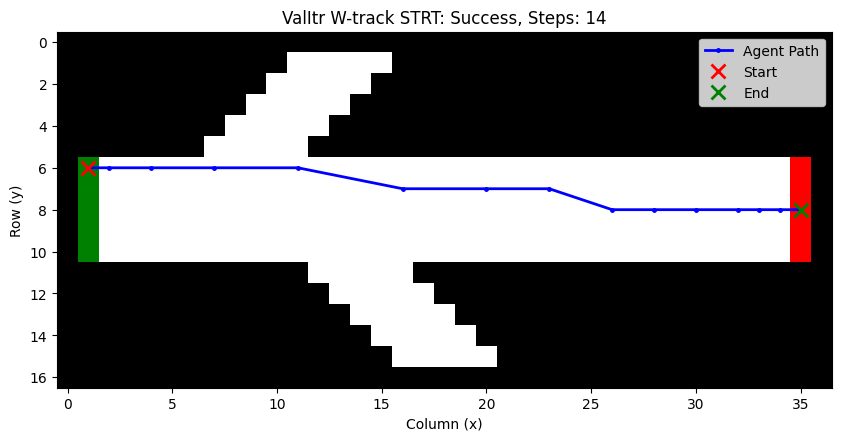

In [ ]:
# TO EXECUTE ALL ALGORITHMS BASED ON HYPERPARAMETERS-- main execution block

#load track
track_obj = load_track(TRACK_NAME)
track_filename = os.path.basename(TRACK_NAME).split('.')[0]
# load nrst lookup table
nrst_table = NRST(track_obj["grid"])

# VALUE ITERATION
if ALGORITHM == 'ValItr':
    states, actions = racetrack_MDP(track_obj["grid"], track_obj["start"], track_obj["finish"])

    #run val iteration algorith, return policy
    policy_vi, values_vi, iters = value_iteration(track_obj, states, actions, 0.99, 0.01, CRASH_POS)

    # simulate policy, get the path, steps and if it finished
    path, steps, finished = run_simulation(policy_vi, track_obj, CRASH_POS, nrst_table)

    # check if it finished
    if finished:
          success_label = "Success"
    else:
          success_label = "Failure"
    # create image and path visualization and save it
    img_name = f"{GROUP_ID}_{ALGORITHM}_{track_filename}_{CRASH_POS}.png"
    visualize_race(track_obj, path, f"{ALGORITHM} {track_filename} {CRASH_POS}: {success_label}, Steps: {steps}", img_name)

#Q LEARNING
elif ALGORITHM == 'QLrng':
    # run multiple iterations of q learning (up to 10) until a path is found
    success_found = False

    for i in range(1, 11):
      final_Q = q_learning(track_obj, 200000, 0.99, 0.7, 1.0, 'STRT')
      # convert the final Q to a policy
      final_policy = q_to_policy(final_Q, track_obj)
      # run a simulation of this policy to get the path, num of steps and if it finished
      path, steps, finished = run_simulation(final_policy, track_obj, CRASH_POS, nrst_table)

      # if success then save the image showing the path/create the image, if failure, indicate it
      if finished:
          success_label = "Success"
          break
      else:
           success_label = "Failure"
    # create image showing path and save it
    img_name = f"{GROUP_ID}_{ALGORITHM}_{track_filename}_{CRASH_POS}.png"
    visualize_race(track_obj, path, f"{ALGORITHM} {track_filename} {CRASH_POS}: {success_label}, Steps: {steps}", img_name)

#SARSA
elif ALGORITHM == 'SARSA':
    # initialize success tracker
    success_found = False
    # give the agent 10 tries to find a path
    for i in range(1, 11):
      # run sarasa
      final_policy, Q_final = sarsa(track_obj, 20000, 0.1, 0.99, 0.05, 'STRT')
      # simulate the final policy and see what happens
      path, steps, finished = run_simulation(final_policy, track_obj, CRASH_POS, nrst_table)
      #check if it was successful
      if finished:
          success_label = "Success"
          break
      else:
          success_label = "Failure"
         # generate image
    img_name = f"{GROUP_ID}_{ALGORITHM}_{track_filename}_{CRASH_POS}.png"
    visualize_race(track_obj, path, f"{ALGORITHM} {track_filename} {CRASH_POS}: {success_label}, Steps: {steps}", img_name)